# This is the template for coursework B - Add a suitable title

Student number: Your Student number here, will be marked anonymously

This Coursework contributes <b>80%</b> to your overall unit mark.

### Abstract: 

Here, give an overview of your work, make sure to describe the science background, methods, results as well as comparisons to literature data. Keep short, not to exceed 250 words.

#### Imports: give all your imports in a box here. Any custom code you have stored in a .py file needs to be submitted with your coursework. You can freely use all code provided to you as part of this course. If you use code not encountered in the course, give a link to the online repo.

In [1]:
import numpy
from astropy.io import fits #used to open fits files in which data are stored
import pylab #plotting
import glob
import numpy as np 
import pandas as pd
import seaborn as sns
import scipy.signal
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from scipy.signal import lombscargle 
import scipy.optimize

from scipy import interpolate
from scipy.optimize import curve_fit
from CompSample import conflevels, density_scatter

from functions import import_and_flatten_lightcurve
from functions import fold_lightcurve
from functions import planet_radius
from functions import semi_major_axis
from functions import planet_temperature

#example of using equations in markdown cell 
$\frac{1}{2}=x^2$

$\frac{∆F}{F} =  \frac{R  planet^2}{R  star^2}$

### 1. Introduction:

Give an introduction to your coursework. This should be a short description of exoplanets as well as a description of background relevant to your Discussion.

Your introduction should be understandable to a student having taken Intro to astro and Planets & Exoplanets. 

Guidline word limit: 300-500 words

### 2. Results - Modelling of Kepler lightcurve

$\bullet$ describe fitting of transit depths and present results with errors

$\bullet$ describe periodogram and identification of periodic features in lightcurves

$\bullet$ describe motivation for any additional fitting you have done

$\bullet$ include code for all modelling in attached code or inline, describe limitations and assumptions made

In [2]:
#the function below cleans the data and flattens the lightcurve using a median filter with kernal size of 101 days
alldata = import_and_flatten_lightcurve()
alldata.head()

,time,flux,error,new flux
0,131.512045,1.000088,0.000141,1.000687
1,131.532480,1.000061,0.000141,1.000557
2,131.552914,0.999893,0.000141,1.000229
3,131.573349,0.999667,0.000141,1.000000
4,131.593783,0.999685,0.000141,1.000004


<ErrorbarContainer object of 3 artists>

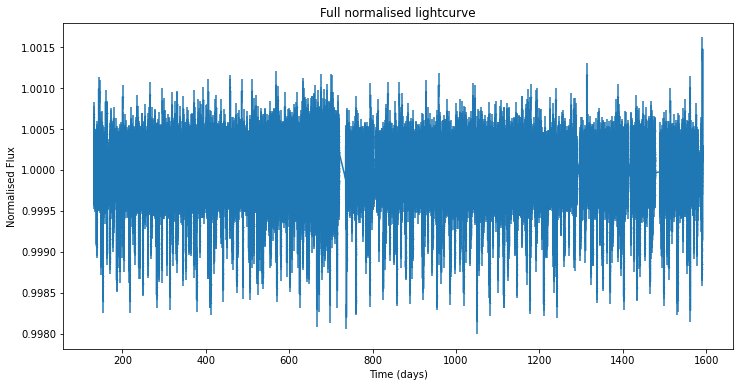

In [3]:
pylab.figure(figsize=(12,6))
pylab.xlabel('Time (days)')
pylab.ylabel('Normalised Flux')
pylab.title('Full normalised lightcurve')
pylab.errorbar(alldata['time'], alldata['new flux'],alldata['error'], ls=None, marker='o', ms=0.5)
#pylab.plot(data['time'], data['new flux'])

In [4]:
#add extra zero to freqs 
freqs = np.linspace(1/670., (1/0.02043), 1000)
lomb = scipy.signal.lombscargle(alldata['time'], alldata['new flux'], freqs, precenter = True)

freqs2 = np.linspace(1/48.9461, (1/0.004895), 1000)
lomb2 = scipy.signal.lombscargle(freqs, lomb, freqs2, precenter = True)

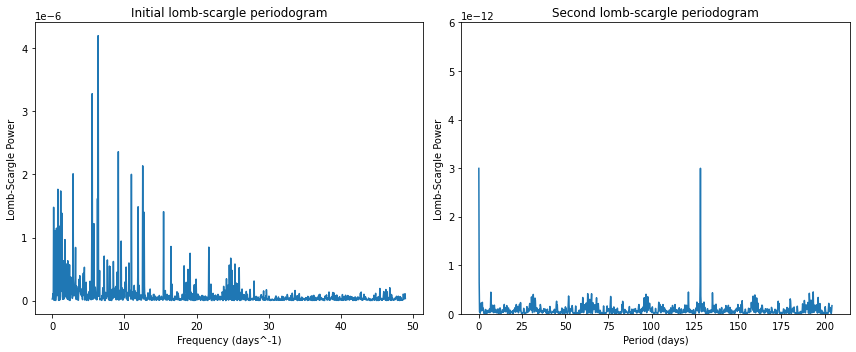

In [5]:
pylab.figure(figsize=(12,5))
pylab.subplot(1,2,1, ylabel='Lomb-Scargle Power', xlabel='Frequency (days^-1)', title='Initial lomb-scargle periodogram')
pylab.plot(freqs,lomb)

pylab.subplot(1,2,2, ylabel='Lomb-Scargle Power', xlabel='Period (days)',ylim=(0,0.6e-11),title='Second lomb-scargle periodogram')
pylab.plot(freqs2,lomb2)
plt.tight_layout()

The second lomb-scargle periodogram shows clear peaks, repeating every period, with no aliasing.  From this second graph, masks were used to zoom into a peak and determine the period.  We then folded the lightcurve to each period to view a clear transit.  

In [6]:
period = 31.9961
fold_data = fold_lightcurve('test_fold.csv', period)

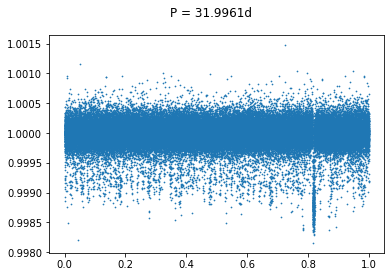

In [7]:
titletext = 'P = ' + str(np.around(period, decimals=4)) + 'd'
plt.suptitle(titletext)
pylab.plot(fold_data['Phase'], fold_data['mag'],marker='o', ls='None', ms=0.7)

In [8]:
x=np.array(fold_data['Phase'])
y=np.array(fold_data['mag'])
err=np.array(fold_data['error'])

In [9]:
def lightcurve_model(t, base_flux, transit_flux):
    model=np.ones(len(t))
    #period = 22.6 days 
    #t_start = 0.546
    #t_end = 0.55
    #period = 13.0 days 
    #t_start = 0.603
    #t_end = 0.615
    #period = 31 days 
    t_start = 0.816
    t_end= 0.8195
    
    for i in range(0,len(t)):
        if (t[i] > t_start) and (t[i] < t_end):
            model[i] = transit_flux
        else: 
            model[i] = base_flux
    return model 

In [10]:
popt, pcov = curve_fit(lightcurve_model,x, y, sigma=err,absolute_sigma=True, p0=[1, 0.999])

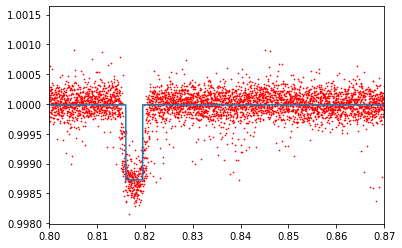

In [11]:
plt.xlim(0.8, 0.87)
pylab.plot(x, y, c='r', marker='o',ls='None', ms=0.7)
model_y = lightcurve_model(x, popt[0], popt[1])
pylab.plot(x, model_y)

In [12]:
planet_radius(popt, pcov)

Radius of planet in Jupiter masses is 3.6785e-01 +/- 6.9079e-03
Radius of planet in Earth masses is 4.1278e+00 +/- 7.7517e-02


In [13]:
#putting all planet properties together into a dataframe
mass_j = 1.9e27
mass_e = 5.972e24

mass_p = [0.023*(mass_j/mass_e), 0.009*(mass_j/mass_e), 0.025*(mass_j/mass_e)] #planet mass (Earth mass)
mass_p_err = [0.004*(mass_j/mass_e), 0.005*(mass_j/mass_e), 0.006*(mass_j/mass_e)]  #planet mass error (Earth mass)

planet_names = ['Planet 1', 'Planet 2', 'Planet 3']
period_p = [22.6845, 13.0249, 31.9961]  #planet period in days 

planet_info = pd.DataFrame({'planet': planet_names,'period':period_p, 'mass': mass_p, 'mass err':mass_p_err})

#stellar properties in comparison to sun (solar radii and solar mass units)
stellar_info = pd.DataFrame({'radius':1.065, 'radius err':0.02, 'mass':0.961, 'mass err':0.025, 'temp':5657}, index=[0])

In [14]:
radius_p = [3.3475e+00,3.0556e+00,4.1278e+00]  #in Earth radii 
radius_p_err = [6.2864e-02,5.7383e-02,7.7517e-02]  #in Earth radii 
planet_info['radius'] = radius_p
planet_info['radius err'] = radius_p_err

In [15]:
planet_info['semi_major'] = semi_major_axis(planet_info['period'])  #in AU 
planet_info['temperature'] = planet_temperature(planet_info['semi_major'])  #in Kelvin

In [16]:
planet_info.set_index('planet')

,period,mass,mass err,radius,radius err,semi_major,temperature
planet,,,,,,,
Planet 1,22.6845,7.317482,1.272605,3.3475,0.062864,0.486133,403.838115
Planet 2,13.0249,2.863362,1.590757,3.0556,0.057383,0.335829,485.876145
Planet 3,31.9961,7.953784,1.908908,4.1278,0.077517,0.611411,360.095776


In [17]:
stellar_info.head()

,radius,radius err,mass,mass err,temp
0,1.065,0.02,0.961,0.025,5657


### 3. Discussion

$\bullet$ present comparison of your results with data, including statistical analyis and clear figures. 

$\bullet$ limit yourself in the presentation of results, focus on fewer results that are described well, rather than presenting many figures without clear context

$\bullet$ Include a short (up to 200 word) description of a follow-up observations that would address an open question in your report.


In [18]:
NASA_data = pd.read_csv('NASA archive data 2.csv', delimiter=',')
NASA_data

,discoverymethod,rv_flag,tran_flag,micro_flag,ima_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,...,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,st_lum,st_lumerr1,st_lumerr2,st_lumlim
0,Radial Velocity,1,0,0,0,NaN,NaN,NaN,NaN,1.21000,...,NaN,NaN,2.60,0.40,-0.30,0.0,NaN,NaN,NaN,NaN
1,Radial Velocity,1,0,0,0,326.03000,0.32,-0.32,0.0,1.29000,...,-2.00,0.0,2.70,0.30,-0.30,0.0,2.243,0.071,-0.085,0.0
2,Radial Velocity,1,0,0,0,516.22000,3.25,-3.25,0.0,1.54000,...,-1.84,0.0,1.80,0.25,-0.25,0.0,NaN,NaN,NaN,NaN
3,Radial Velocity,1,0,0,0,NaN,NaN,NaN,NaN,1.51000,...,NaN,NaN,1.70,0.40,-0.30,0.0,NaN,NaN,NaN,NaN
4,Radial Velocity,1,0,0,0,516.21997,3.20,-3.20,0.0,1.53000,...,-2.84,0.0,2.78,0.69,-0.69,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26883,Radial Velocity,1,0,0,0,1319.00000,18.00,-18.00,0.0,2.57000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26884,Radial Velocity,1,0,0,0,1278.10000,2.90,-2.90,0.0,2.53000,...,-0.08,0.0,1.15,0.15,-0.15,0.0,0.525,0.015,-0.016,0.0
26885,Radial Velocity,1,0,0,0,1276.46000,0.57,-0.57,0.0,2.51329,...,NaN,0.0,1.30,NaN,NaN,0.0,NaN,NaN,NaN,NaN
26886,Radial Velocity,1,0,0,0,136.75000,0.25,-0.25,0.0,0.68000,...,NaN,0.0,2.20,NaN,NaN,0.0,1.839,NaN,NaN,0.0


In [19]:
data_kde = pd.DataFrame({'log period': np.log10(NASA_data['pl_orbper']), 'log radius':np.log10(NASA_data['pl_rade'])})
data_kde.dropna(inplace=True)

In [20]:
NASA2 = NASA_data.dropna()

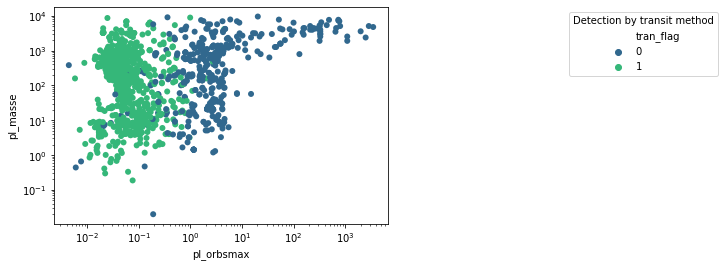

In [21]:
#graph to demonstrate the selection effects of the transit method 
ax = sns.scatterplot(x=(NASA_data['pl_orbsmax']), y=(NASA_data['pl_masse']), marker='o', hue=NASA_data['tran_flag'],linewidth=0, palette='viridis')
ax.set(xscale='log', yscale='log')
ax.legend(bbox_to_anchor=(2,1), title='Detection by transit method')

In [22]:
levels = conflevels(data_kde['log period'],data_kde['log radius'],nbins=200,confints=[0.997,0.8,0.68])
print(levels)

[0.08790449595510054, 0.35161798381868326, 0.5274269757254465]


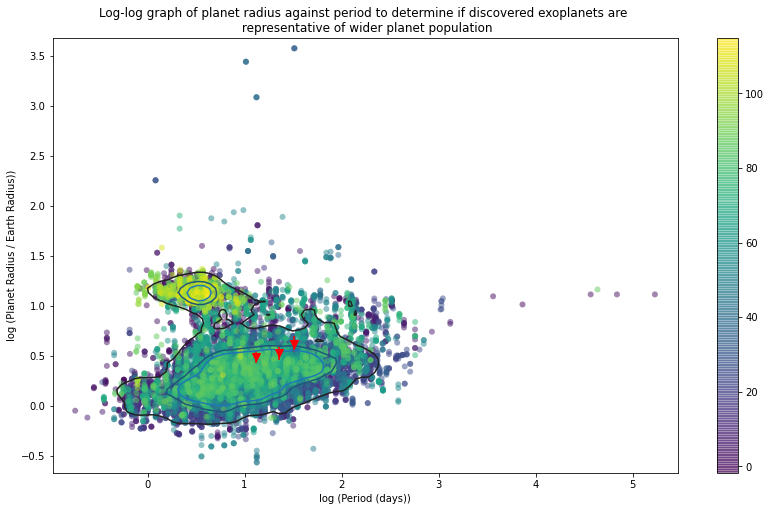

In [23]:
#graph to anwer is this planet an outlier or representative of the population?? 

pylab.figure(figsize=(14,8))

dencol=density_scatter(np.array(data_kde['log period']), np.array(data_kde['log radius']), bins = [100,100])
levels = conflevels(data_kde['log period'],data_kde['log radius'],nbins=200,confints=[0.997,0.8,0.68])

#scatter plot of NASA exoplanet data points 
pylab.scatter(data_kde['log period'], data_kde['log radius'], c=dencol, cmap='viridis', linewidth=0, alpha=0.5)

#planet data points 
pylab.errorbar(np.log10(planet_info['period']), np.log10(planet_info['radius']), (planet_info['radius err']), ls='None', marker='v', c='r', ms=8)

#pylab.plot(np.log10(planet_info['period']), np.log10(planet_info['radius']), ls='None', marker='v', c='b', ms=8)


#pylab.xlabel=('Log (Period in days)')
#pylab.ylabel=('Log (Planet Radius / Earth Radius)')

#kde confidece levels plot
ax = sns.kdeplot(data_kde['log period'],data_kde['log radius'], n_levels=levels)
ax.set(xlabel ='log (Period (days))', ylabel = 'log (Planet Radius / Earth Radius))', title='Log-log graph of planet radius against period to determine if discovered exoplanets are \n representative of wider planet population')
plt.colorbar()

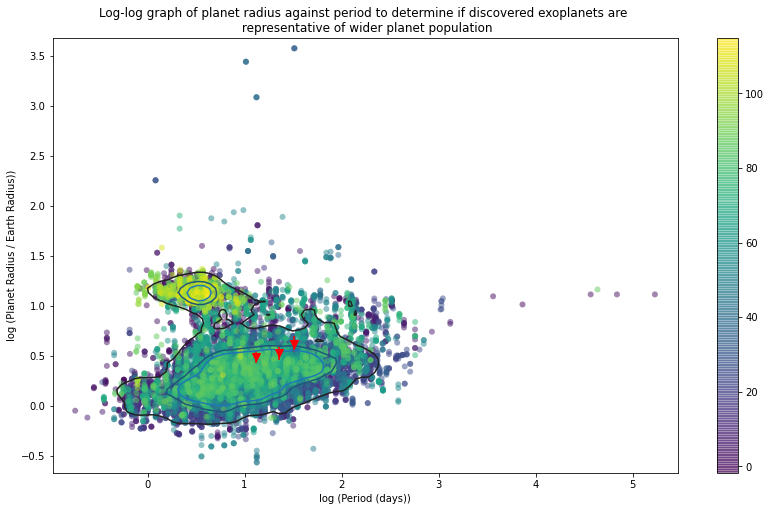

In [24]:
#graph to anwer is this planet an outlier or representative of the population?? 

pylab.figure(figsize=(14,8))

dencol=density_scatter(np.array(data_kde['log period']), np.array(data_kde['log radius']), bins = [100,100])
levels = conflevels(data_kde['log period'],data_kde['log radius'],nbins=200,confints=[0.997,0.8,0.68])

#scatter plot of NASA exoplanet data points 
pylab.scatter(data_kde['log period'], data_kde['log radius'], c=dencol, cmap='viridis', linewidth=0, alpha=0.5)

#planet data points 
pylab.errorbar(np.log10(planet_info['period']), np.log10(planet_info['radius']), (planet_info['radius err']), ls='None', marker='v', c='r', ms=8)

#pylab.plot(np.log10(planet_info['period']), np.log10(planet_info['radius']), ls='None', marker='v', c='b', ms=8)


#pylab.xlabel=('Log (Period in days)')
#pylab.ylabel=('Log (Planet Radius / Earth Radius)')

#kde confidece levels plot
ax = sns.kdeplot(data_kde['log period'],data_kde['log radius'], n_levels=levels)
ax.set(xlabel ='log (Period (days))', ylabel = 'log (Planet Radius / Earth Radius))', title='Log-log graph of planet radius against period to determine if discovered exoplanets are \n representative of wider planet population')
plt.colorbar()

Figure A: ...

In [25]:
def density_func(density, mass): 
    "input: density in kg/m^3 eg. desnity of water = 997"
    "returns: radius as function of mass"
    
    earth_radius = 6.371e6
    earth_mass = 5.972e24
    
    r = (3/(4 * np.pi * density))**(1/3) * ((mass*earth_mass)**(1/3))
    return r/earth_radius

mass = np.array(NASA_data['pl_masse'])
sorted_mass = np.sort(mass)

water = density_func(997, sorted_mass)
air = density_func(1.225, sorted_mass)
rock = density_func(2960, sorted_mass)

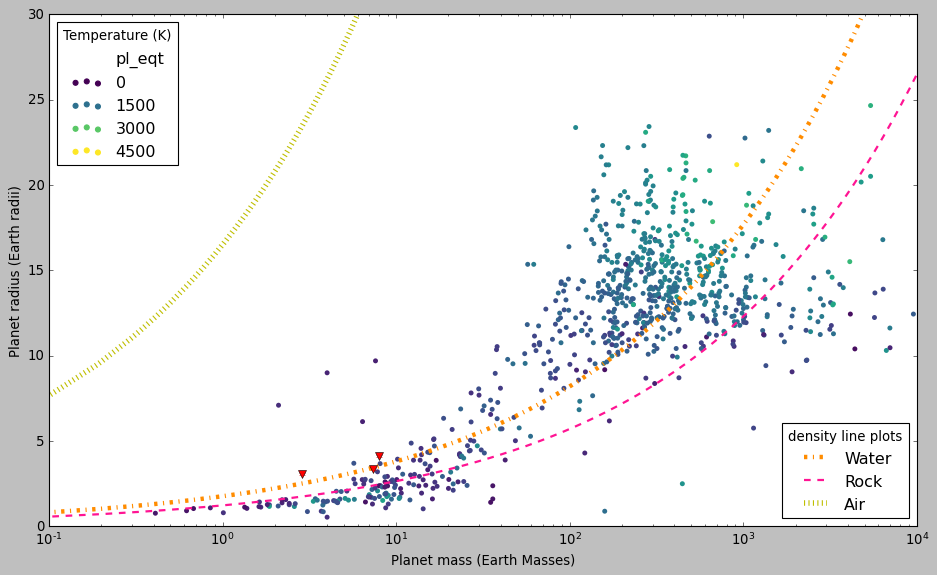

In [31]:
#graph to answer question is planet terrestial? 

#pallette - MAKO is good or COOLWARM
pylab.figure(figsize=(14,8))
pylab.ylim(0,30)
pylab.xlim(1/10, 10000)

pylab.errorbar((planet_info['mass']), (planet_info['radius']), planet_info['radius err'], ls='None', marker='v', c='r', ms=8)

#pylab.plot((planet_info['mass']), (planet_info['radius']), ls='None', marker='v', c='r', ms=10)
#pylab.axhline(y=2, c='r', ls='--')
#pylab.axvline(x=10, c='r', ls='--')
ax = sns.scatterplot(x=(NASA_data['pl_masse']), y=(NASA_data['pl_rade']), marker='o', hue=NASA_data['pl_eqt'],linewidth=0, palette='viridis')
ax.set(xlabel='Planet mass (Earth Masses)', ylabel = 'Planet radius (Earth radii)', xscale='log')#, yscale='log')
legend1 = ax.legend(title='Temperature (K)', loc=2)

water_plot, = ax.plot(sorted_mass, water, label='water', c='darkorange', ls='-.', lw=4)
rock_plot, = ax.plot(sorted_mass, rock, label='rock', c='deeppink', ls='--', lw=2)
air_plot, = ax.plot(sorted_mass, air, label='air', c='y', ls=':', lw=5)
legend2 = ax.legend([water_plot, rock_plot, air_plot],['Water', 'Rock', 'Air'], title='density line plots', loc=4)
ax.add_artist(legend1)

#ax = sns.lmplot(x='pl_masse', y='pl_rade', hue='pl_eqt', palette='viridis', data=NASA_data)

#wide variety of densities due to scatter of masses for any particular radius

Figure B: ........

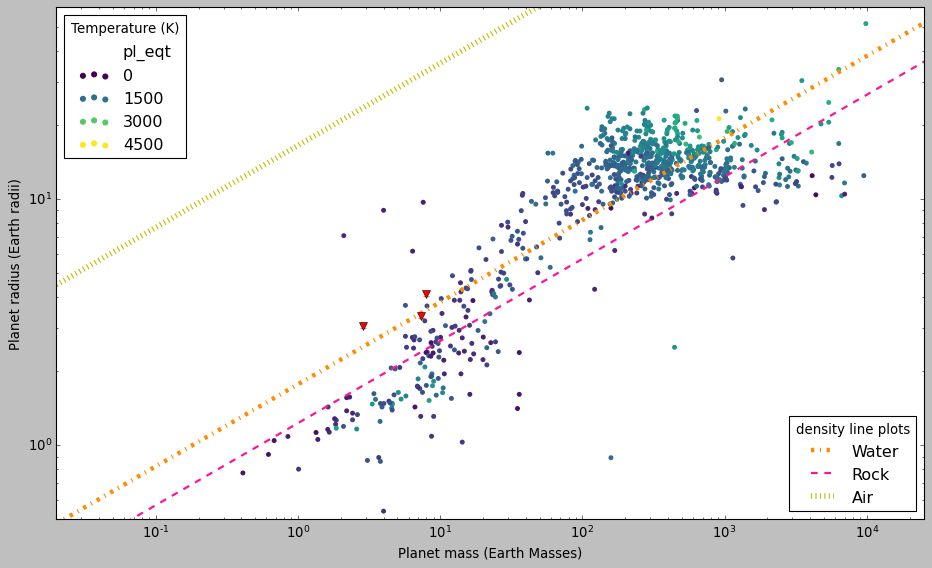

In [27]:
#graph to answer question is planet terrestial? 
plt.style.use('classic')
#pallette - MAKO is good or COOLWARM
pylab.figure(figsize=(14,8))
pylab.ylim(0.5,60)
#pylab.xlim(1/10, 10000)
pylab.errorbar((planet_info['mass']), (planet_info['radius']), planet_info['radius err'], ls='None', marker='v', c='r', ms=8)

#pylab.plot((planet_info['mass']), (planet_info['radius']), ls='None', marker='v', c='r', ms=10)
#pylab.axhline(y=2, c='r', ls='--')
#pylab.axvline(x=10, c='r', ls='--')
ax = sns.scatterplot(x=(NASA_data['pl_masse']), y=(NASA_data['pl_rade']), marker='o', hue=NASA_data['pl_eqt'],linewidth=0, palette='viridis')
ax.set(xlabel='Planet mass (Earth Masses)', ylabel = 'Planet radius (Earth radii)', xscale='log', yscale='log')
legend1 = ax.legend(title='Temperature (K)', loc=2)

water_plot, = ax.plot(sorted_mass, water, label='water', c='darkorange', ls='-.', lw=4)
rock_plot, = ax.plot(sorted_mass, rock, label='rock', c='deeppink', ls='--', lw=2)
air_plot, = ax.plot(sorted_mass, air, label='air', c='y', ls=':', lw=5)
legend2 = ax.legend([water_plot, rock_plot, air_plot],['Water', 'Rock', 'Air'], title='density line plots', loc=4)
ax.add_artist(legend1)

plt.margins(x=0)
plt.margins(y=0)

#wide variety of densities due to scatter of masses for any particular radius

In [28]:
#graph to show habitable zone for planets... 

In [29]:
stellar_temp = stellar_info['temp'][0]
    
#Stefan-Boltzmann constant 
s_const = 5.67e-8
#Solar radius 
solar_radius = 6.96e8

stellar_luminosity = 4*np.pi * (stellar_info['radius'][0]*solar_radius)**2 * s_const * stellar_temp**4
print(stellar_luminosity)

4.0091779455942324e+26


In [30]:
np.nanmean(NASA_data['pl_orbsmax'])

1.8990739989420622

### 4. Summary

$\bullet$ summarize your results in a bullet point format. Not to exceed 300 words.

### References:

Give all references here. Use Astronomy style references, e.g.
- Miller & Jones, 2018, ApJ, 00, 000
- Smith et al. 2019, MNRAS, 00, 000
- Willow 1972, AJ, 00, 000

And cite these in the text as "Miller & Jones (2018) showed that all exoplanets are made of cheese, however, Smith et al. (2019) showed Trappist1b is made of chocolate, as previously suggested in the literature (Willow 1972)." 